In [1]:
import numpy as onp
import jax.numpy as np
from jax import random
from jax import jit
from jax_md.util import *
import matplotlib.pyplot as plt
key = random.PRNGKey(0)
from jax_md import quantity
import jax_md
print(dir(jax_md))
from jax_md import energy, partition
from jax_pd import space, materials, damage, mesh, plots, solvers, util


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'energy', 'interpolate', 'minimize', 'partition', 'quantity', 'simulate', 'smap', 'space', 'util']


/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
displacement_fn, shift_fn = space.free()

R = onp.array([[i,j,k] for i in range(10) for j in range(20) for k in range(20)],dtype=np.float32)

mask = (R[:,0]<2)|((R[:,0]>4)&(R[:,1]>8)&(R[:,2]>8)&(R[:,1]<12)&(R[:,2]<12))

R = np.array(R[mask])

box_size = [20,20,20]
cutoff = f32(2.5)

bonds = util.bonds(displacement_fn, box_size, cutoff, R)



/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4547: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4547: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4547: 

In [3]:
lengths0 = util.bond_lengths(bonds,R)
bonds.shape


(17502, 2)

In [18]:
energy_fn = [{'func':materials.simple_spring_bond,
              'args':[displacement_fn], 
              'kwargs':dict(bond=bonds,length=lengths0, epsilon=f32(100), stretch=f32(0.1), radius=f32(1), epsilon2=f32(1000))
                 }, 
            {'func':energy.soft_sphere_pair, 
             'args':[displacement_fn], 
             'kwargs':dict(sigma=f32(1), epsilon=f32(1000))
                },
                [bonds,f32(0.1)]]

def cal_energy(R,energy_fn):
    energy_fn_calable = [i['func'](*i['args'],**i['kwargs']) for i in energy_fn[:-1]]
    return np.sum([j(R) for j in energy_fn_calable])

cal_energy(R,energy_fn)

DeviceArray(0., dtype=float32)

In [19]:
def move(R,bool,t=0,R0=R,v=np.array([[0.01,0,0]])):
    return R0[bool,:]+t*v

def fix(R,bool,t=0,R0=R):
    return R0[bool,:]


Rbc = []

iVbc = [{'bool':R[:,0]>4,'fn':fix,'kwargs':{'R0':R*0-np.array([[20,0,0]])}},
#        {'bool':R[:,0]<8,'fn':fix,'kwargs':{'R0':R*0+np.array([[0,0,0]])}},
       ]


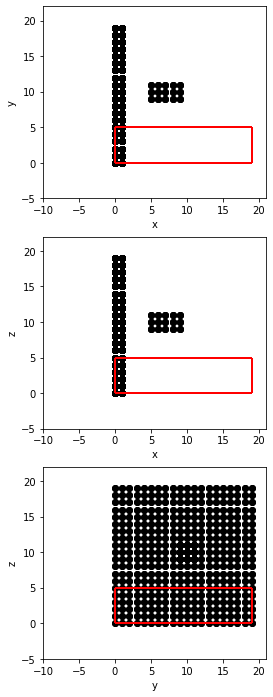

In [20]:
R1 = [R]

def myplot(i):
    x,y = 1,3
    fig, axs = plt.subplots(y,x,figsize=[4*x,4*y])
    ls = []
    ms = 5
    labels = [['x','y'],['x','z'],['y','z']]
    for ax,label in zip(axs,labels):
        ls.append(ax.plot([],[],'o', markersize=ms)[0])
        ax.set_xlim([-10, 21])
        ax.set_ylim([-5, 22])
        ax.hlines(0,0,19,zorder=10,color='r',lw=2)
        ax.hlines(5,0,19,zorder=10,color='r',lw=2)
        ax.vlines(0,0,5,zorder=10,color='r',lw=2)
        ax.vlines(19,0,5,zorder=10,color='r',lw=2)
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.axis('on')

    plots.W3(i,R1,axs,color='k')
    plt.show()

myplot(0)


In [21]:
R1 = [R]
runs = 500
R2, state_values, states = solvers.run_simulation(key,runs,1.0e-3, R,energy_fn,shift_fn,iVbc=iVbc,mass=1.0,print_every=20,value_every=20,pos_every=10)

R1 += R2


Initial conditions(after iBC): 
KE: 9000.000000, PE: 0.000, TE: 9000.000
Initial conditions(after BC): 
KE: 9000.000000, PE: 0.000, TE: 9000.000
Run # 0 :  KE: 9000.000000, PE: 0.000, TE: 9000.000
Run # 20 :  KE: 9000.000000, PE: 0.000, TE: 9000.000
Run # 40 :  KE: 9000.000000, PE: 0.000, TE: 9000.000
Run # 60 :  KE: 9000.000000, PE: 0.000, TE: 9000.000
Run # 80 :  KE: 9000.000000, PE: 0.000, TE: 9000.000
Run # 100 :  KE: 9000.000000, PE: 0.000, TE: 9000.000
Run # 120 :  KE: 9000.000000, PE: 0.000, TE: 9000.000
Run # 140 :  KE: 9000.000000, PE: 0.000, TE: 9000.000
Run # 160 :  KE: 8796.710938, PE: 203.288, TE: 8999.999
Run # 180 :  KE: 8057.181152, PE: 943.063, TE: 9000.244
Run # 200 :  KE: 7808.003906, PE: 1192.088, TE: 9000.092
Run # 220 :  KE: 7408.874023, PE: 1584.271, TE: 8993.146
Run # 240 :  KE: 6650.455566, PE: 2234.064, TE: 8884.520
Run # 260 :  KE: 6418.953613, PE: 2244.365, TE: 8663.318
Run # 280 :  KE: 6540.122070, PE: 2012.431, TE: 8552.553
Run # 300 :  KE: 6183.366699, PE

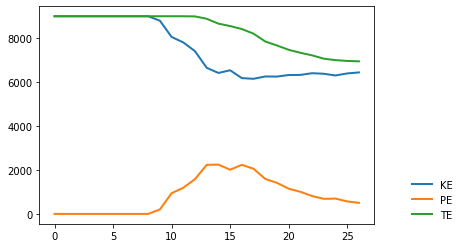

In [22]:
plt.plot(range(len(state_values)),np.array(state_values),lw=2)
plt.legend(['KE','PE','TE'],frameon=False,loc=[1.1,0])




In [12]:
F1 = []
F2 = []
mask1 = R[:,0]>4
mask2 = R[:,0]<4

F1 += [(state.acceleration[mask1,0]*state.mass).sum() for state in states]
F2 += [(state.acceleration[mask2,0]*state.mass).sum() for state in states]
    

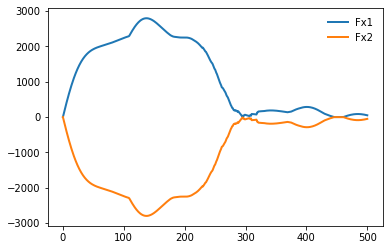

In [13]:
plt.plot(range(len(F1)),F1,label='Fx1',lw=2)
plt.plot(range(len(F2)),F2,label='Fx2',lw=2)
plt.legend(frameon=0)


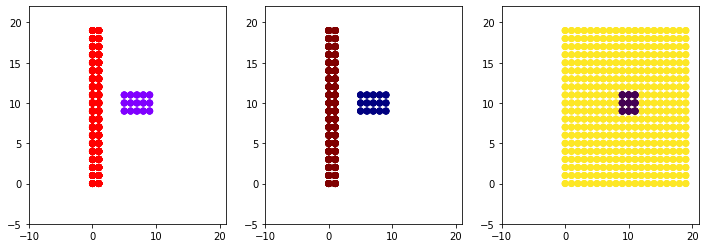

In [50]:
import matplotlib
k = 1
ms = 5

mask = R[:,0]<3

def myplot(i):
    global axs,l,k
    i = i*k
    R_plt = onp.array(R1[i])
    for ax in axs:
        ax.clear()
        ax.set_xlim([-10, 21])
        ax.set_ylim([-5, 22])

    axs[0].scatter(R_plt[:, 0], R_plt[:, 1],c=mask,cmap='rainbow') 
    axs[1].scatter(R_plt[:, 0], R_plt[:, 2],c=mask,cmap='jet') 
    axs[2].scatter(R_plt[:, 1], R_plt[:, 2],c=mask,cmap='viridis') 

    

fig, axs = plt.subplots(1,3,figsize=[12,4])
ls = []
for ax in axs:
    ax.set_xlim([-10, 21])
    ax.set_ylim([-5, 22])
    ax.hlines(0,0,19,zorder=10,color='r',lw=2)
    ax.hlines(5,0,19,zorder=10,color='r',lw=2)
    ax.vlines(0,0,5,zorder=10,color='r',lw=2)
    ax.vlines(19,0,5,zorder=10,color='r',lw=2)
    ax.axis('on')


from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, myplot, frames=int(len(R1)/k))

from IPython.display import HTML
HTML(ani.to_jshtml())





In [66]:
with open('./datafile.xyz','w+') as f:
    for r in R1:
        f.write(str(len(r))+'\n\n')        
        for i,t in zip(r,mask):
            f.write('{} {} {} {}\n'.format(*i,t))
        